# 4. Basic use of Probeye

This package provides a transparent and easy-to-use framework for solving parameter estimation problems (i.e., inverse problems) primarily via sampling methods in a characteristic two-step approach.

Some of the features include: 
- Multiple prior types accepted
- Measurement data bookkeeping
- Various methods supported
- Postprocessing functionalities 


You can install the most recent stable version simply by running pip from the command line:

```
pip install probeye
```



More information can be found the [Pobeye documentation page](https://probeye.readthedocs.io/en/latest/index.html)

```{exercise}
:label: exercise4
:number: 4
Solve [exercise 3](#exercise3), but using Probeye with the **emcee** solver
```

% An admonition containing a note
:::{note}
`emcee` is a package implementing the “Affine invariant ensemble sampler” MCMC method

Nice things about emcee : 
- You don’t need to provide a proposal distribution (usually difficult to hand-tune)
- Can handle parameters with different orders of magnitude
- It’s highly parallelizable  

:::



:::{hint}
:class: dropdown

Steps to follow: 
1. Define ForwardModelBase child class
2. Instantiate InverseProblem
3. Add Latent parameters
4. Add Fixed parameters
5. Add Experiment
6. Add Forward model
7. Add Likelihood model
8. Solve with emcee

See [Probeye simple linear regresion example](https://probeye.readthedocs.io/en/latest/auto_examples/plot_linear_regression.html)

:::

### Import necessary libraries

In [1]:
# Problem definition
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel

# Inference
from probeye.inference.emcee.solver import EmceeSolver

# Postprocessing
from probeye.postprocessing.sampling_plots import create_posterior_plot

## Problem setup

In [2]:
# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm
Q = 100  # kN

# Measurements
x_meas = 5000  # mm
d_meas = 50  # mm
sigma_meas = 10  # mm

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa

## Define forward model

In [ ]:
def midspan_deflection(E):
    return Q * L ** 3 / (48 * E * I)

class BeamModel(ForwardModelBase):
    def interface(self):
        self.parameters = ["E"]
        self.input_sensors = Sensor("x")
        self.output_sensors = Sensor("y", std_model="sigma")

    def response(self, inp: dict) -> dict:
        E = inp["E"]
        return {"y": midspan_deflection(E)}

## Define inverse problem

In [5]:
# Instantiate the inverse problem
problem = InverseProblem("Beam model with one sensor", print_header=False)

# Add latent parameters
problem.add_parameter(
    "E",
    tex="$E$",
    info="Elastic modulus of the beam (GPa)",
    prior=Normal(mean=E_mean, std=E_std),
)

# Add fixed parameters
problem.add_parameter(
    "sigma",
    tex="$\sigma$",
    info="Standard deviation of the measurement error (mm)",
    value=sigma_meas,
)

# Add measurement data
problem.add_experiment(
    name="TestSeries_1",
    sensor_data={"x": x_meas, "y": d_meas}
)

# Add forward model
problem.add_forward_model(BeamModel("BeamModel"), experiments="TestSeries_1")

# Add likelihood model
problem.add_likelihood_model(
    GaussianLikelihoodModel(experiment_name="TestSeries_1", model_error="additive")
)

## Solve with MCMC

In [6]:
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=2000, n_initial_steps=2000)

2024-07-08 21:20:21.338 | INFO     | Solving problem using emcee sampler with 2000 + 2000 samples and 20 walkers                          | probeye.inference.emcee.solver:run:178
2024-07-08 21:20:21.339 | INFO     | No additional options specified                                                                      | probeye.inference.emcee.solver:run:186


100%|██████████| 2000/2000 [00:06<00:00, 288.36it/s]

2024-07-08 21:20:35.993 | INFO     | Sampling of the posterior distribution completed: 2000 steps and 20 walkers.                         | probeye.inference.emcee.solver:run:255
2024-07-08 21:20:35.994 | INFO     | Total run-time (including initial sampling): 14s.                                                    | probeye.inference.emcee.solver:run:259
2024-07-08 21:20:35.994 | INFO     |                                                                                                      | probeye.inference.emcee.solver:run:260
2024-07-08 21:20:35.995 | INFO     | Summary of sampling results (emcee)                                                                  | probeye.inference.emcee.solver:run:261
2024-07-08 21:20:35.999 | INFO     |       mean    median     sd     5%    95%                                                            | probeye.inference.emcee.solver:emcee_summary:137
2024-07-08 21:20:35.999 | INFO     | --  ------  --------  -----  -----  -----                 

## Plot

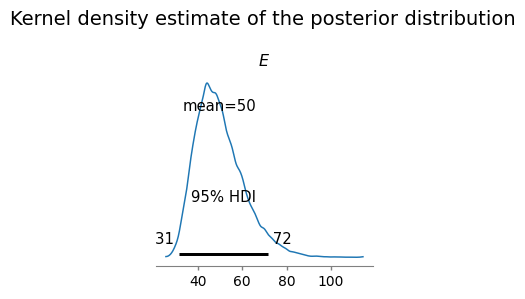

In [7]:
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    kind="kde",
    title="Kernel density estimate of the posterior distribution",
)

:::{note} Complete Code! 📃💻
:class: dropdown
Here’s the complete code that you would run in your PC:


```python
# Problem definition
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel

# Inference
from probeye.inference.emcee.solver import EmceeSolver

# Postprocessing
from probeye.postprocessing.sampling_plots import create_posterior_plot

# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm
Q = 100  # kN

# Measurements
x_meas = 5000  # mm
d_meas = 50  # mm
sigma_meas = 10  # mm

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa


#Define the forward model
def midspan_deflection(E):
    return Q * L ** 3 / (48 * E * I)

class BeamModel(ForwardModelBase):
    def interface(self):
        self.parameters = ["E"]
        self.input_sensors = Sensor("x")
        self.output_sensors = Sensor("y", std_model="sigma")

    def response(self, inp: dict) -> dict:
        E = inp["E"]
        return {"y": midspan_deflection(E)}
    

#Define the inverse problem
# Instantiate the inverse problem
problem = InverseProblem("Beam model with one sensor", print_header=False)

# Add latent parameters
problem.add_parameter(
    "E",
    tex="$E$",
    info="Elastic modulus of the beam (GPa)",
    prior=Normal(mean=E_mean, std=E_std),
)

# Add fixed parameters
problem.add_parameter(
    "sigma",
    tex="$\sigma$",
    info="Standard deviation of the measurement error (mm)",
    value=sigma_meas,
)

# Add measurement data
problem.add_experiment(
    name="TestSeries_1",
    sensor_data={"x": x_meas, "y": d_meas}
)

# Add forward model
problem.add_forward_model(BeamModel("BeamModel"), experiments="TestSeries_1")

# Add likelihood model
problem.add_likelihood_model(
    GaussianLikelihoodModel(experiment_name="TestSeries_1", model_error="additive")
)

#solve with mcmc
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=2000, n_initial_steps=2000)

#plot
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    kind="kde",
    title="Kernel density estimate of the posterior distribution",
)


```
:::

